### Oleksiy Anokhin | Hanwen Serena Xu | Alicia Zhang (August 5, 2020)

### Starbucks App Customer Rewards Program

### MSCA 31008 | Data Mining Principles | Professor U. Pamuksuz | Team Project

In [ ]:
# Import libraries
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import sklearn.model_selection as cv
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split 
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import check_random_state
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
import pycaret
from pycaret.classification import *
from sklearn import linear_model

# Set additional parameters
# Remove column display limits
pd.set_option('display.max_columns', None)
# pd.set_option('display.height', None)
pd.set_option('display.max_rows', None)
# pd.set_option('display.width', None)
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style("white")

# Predicting offer completion for each customer on each offer

In [ ]:
# Read clean data
starbucks = pd.read_csv('starbucks_standarlized.csv')

# Print
starbucks

In [ ]:
# Drop transaction
starbucks = starbucks[starbucks.offer_id != 0]

In [ ]:
# Drop columns
starbucks = starbucks.drop(['Unnamed: 0','customer_id', 'offer_id'], axis = 1)

In [ ]:
# To predict if the offer would be completed
# Remove the feature that indicate the offer has been completed - total_reward
starbucks = starbucks.drop(['time_completed_received','time_completed_received', 
                            'time_completed_viewed'], axis = 1) 
starbucks = starbucks.drop([ 'transaction', 'amount', 'total_reward'], axis = 1)

# also excluded offer_received since all records have the same value 1
starbucks.drop([ 'offer_received'], axis = 1,inplace=True)

In [ ]:
# Drop informational offer related records, because that transactions cannot be tied back to info offers hence no able to predict completion
starbucks = starbucks[starbucks.informational != 1]

# drop informational and discount column to avoid collinearity since we are only predicting bogo and discount
starbucks.drop([ 'informational','discount'], axis = 1,inplace=True)

In [ ]:
starbucks.head()

,offer_viewed,time_viewed_received,offer_completed,age,income,male,membership_days,reward_each_time,difficulty,duration,email,mobile,social,web,bogo
0,1.0,-0.054744,1.0,-0.430855,0.013855,0,0.017615,0.154308,1.42297,2.224767,1.0,1.0,1.0,1.0,0.0
1,1.0,0.612758,0.0,1.019811,-0.275748,1,-0.995737,0.154308,1.42297,2.224767,1.0,1.0,1.0,1.0,0.0
2,1.0,0.501507,1.0,1.019811,0.544795,1,-0.748029,0.154308,1.42297,2.224767,1.0,1.0,1.0,1.0,0.0
3,1.0,-0.054744,1.0,0.908222,1.027467,0,0.990433,0.154308,1.42297,2.224767,1.0,1.0,1.0,1.0,0.0
4,1.0,-0.277245,1.0,0.350273,1.510139,0,-0.610663,0.154308,1.42297,2.224767,1.0,1.0,1.0,1.0,0.0


**Pycaret**

PyCaret is an open source, low-code machine learning library in Python that aims to reduce the cycle time from hypothesis to insights. It is well suited for seasoned data scientists who want to increase the productivity of their ML experiments by using PyCaret in their workflows or for citizen data scientists and those new to data science with little or no background in coding. PyCaret allows you to go from preparing your data to deploying your model within seconds using your choice of notebook environment.

**Classification with Pycaret**

First explore the standardlized dataset.

In [ ]:
py_df = starbucks.copy()
py_df.offer_completed = py_df.offer_completed.astype('category')

In [ ]:
# Initialize Setup
starbucks1 = setup(py_df, target = 'offer_completed', session_id = 123, log_experiment = False, experiment_name = 'starbucks1')

Setup Succesfully Completed!


,Description,Value
0,session_id,123
1,Target Type,Binary
2,Label Encoded,None
3,Original Data,"(71094, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


In [ ]:
#  Compare baseline
best_model = compare_models(sort = 'Recall',fold = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Naive Bayes,0.7734,0.8440,1.0000,0.6307,0.7735,0.5690,0.6305,0.0173
1,Linear Discriminant Analysis,0.8188,0.9042,0.8768,0.7176,0.7892,0.6330,0.6428,0.1136
2,Ridge Classifier,0.8187,0.0000,0.8742,0.7184,0.7887,0.6326,0.6420,0.0292
3,Logistic Regression,0.8225,0.9068,0.8481,0.7344,0.7872,0.6363,0.6412,0.5702
4,Extreme Gradient Boosting,0.8399,0.9283,0.8455,0.7655,0.8035,0.6690,0.6714,1.8323
5,Light Gradient Boosting Machine,0.8396,0.9291,0.8407,0.7673,0.8023,0.6679,0.6699,0.4746
6,Gradient Boosting Classifier,0.8391,0.9283,0.8406,0.7663,0.8017,0.6668,0.6688,4.0262
7,CatBoost Classifier,0.8405,0.9289,0.8392,0.7695,0.8028,0.6693,0.6711,17.5116
8,Ada Boost Classifier,0.8336,0.9236,0.8341,0.7596,0.7951,0.6556,0.6576,1.2893
9,Extra Trees Classifier,0.8235,0.9133,0.8125,0.7517,0.7809,0.6336,0.6349,1.8113


GaussianNB(priors=None, var_smoothing=1e-09)

In [ ]:
# Define columns for prediction
X = starbucks.loc[:, ~starbucks.columns.isin(['offer_completed'])]

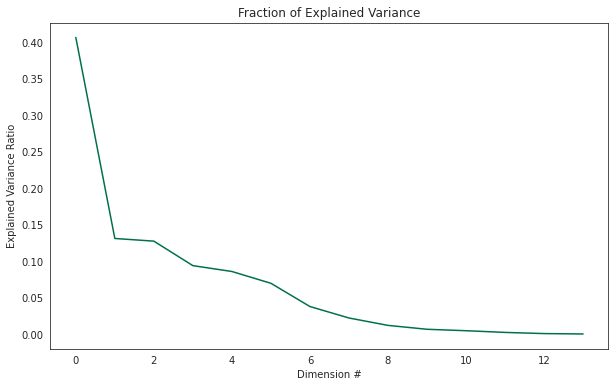

In [ ]:
# Run PCA
ini_pca = PCA(n_components = X.shape[1]).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

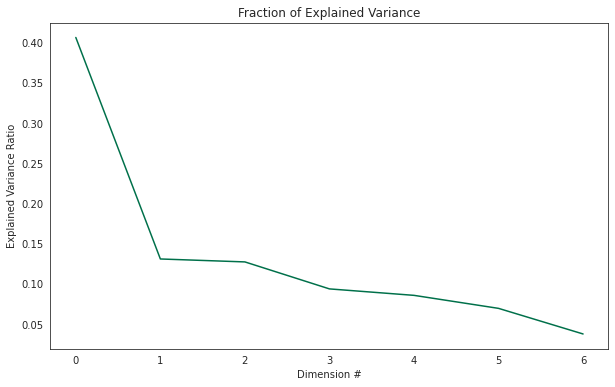

In [ ]:
ini_pca = PCA(n_components = 7).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

In [ ]:
pca = PCA(n_components = 7).fit(X)

In [ ]:
vars = pca.explained_variance_ratio_
c_names = starbucks.loc[:,~starbucks.columns.isin(['offer_completed'])].columns
sum = 0

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, c_names))
    sum += 100*vars[idx]
    print(output)

print('Total variance explained by the 7 components {0:4.1f}%'.format(sum))

Variance:  Projected dimension
------------------------------
40.6%:     0.18 * offer_viewed +  0.25 * time_viewed_received +  0.05 * age +  0.09 * income + -0.01 * male + -0.08 * membership_days +  0.48 * reward_each_time +  0.50 * difficulty +  0.50 * duration +  0.23 * email +  0.18 * mobile +  0.15 * social +  0.18 * web +  0.12 * bogo
13.1%:     0.05 * offer_viewed +  0.95 * time_viewed_received + -0.11 * age + -0.13 * income +  0.02 * male +  0.08 * membership_days + -0.09 * reward_each_time + -0.19 * difficulty + -0.14 * duration + -0.04 * email + -0.00 * mobile + -0.00 * social + -0.04 * web +  0.00 * bogo
12.7%:     0.01 * offer_viewed +  0.14 * time_viewed_received +  0.65 * age +  0.72 * income + -0.11 * male +  0.02 * membership_days + -0.08 * reward_each_time + -0.09 * difficulty + -0.06 * duration + -0.02 * email + -0.01 * mobile + -0.01 * social + -0.02 * web + -0.01 * bogo
 9.4%:     0.01 * offer_viewed + -0.05 * time_viewed_received +  0.02 * age + -0.01 * income +  0.

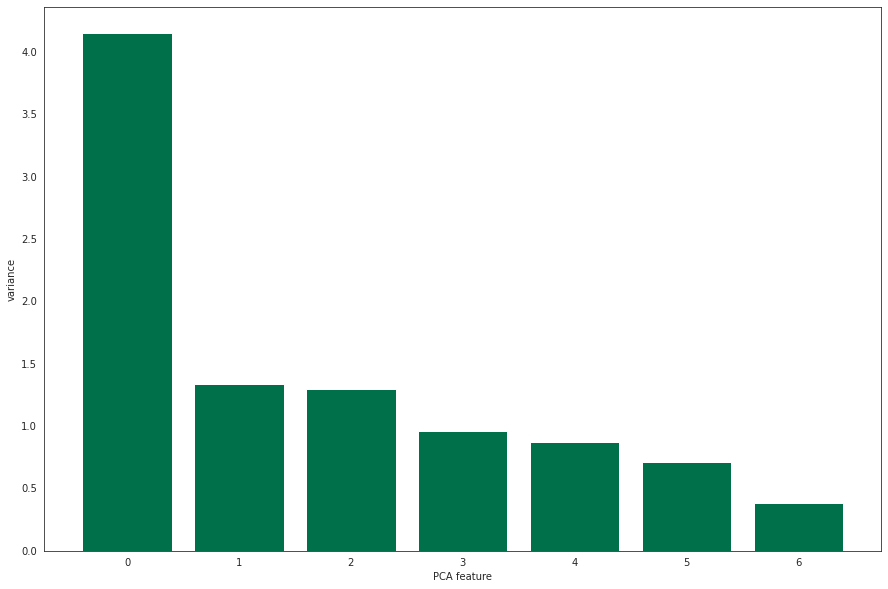

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_, color = '#00704A')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
# Fit the model
X = PCA(n_components = 7).fit_transform(X)
Y = starbucks.loc[:,'offer_completed']

**Logistic Regression with standartized data (function)**

In [ ]:
# Function importing Dataset 
def importdata(): 

    # Printing the dataswet shape 
    print ("Dataset Length: ", len(starbucks)) 
    print ("Dataset Shape: ", starbucks.shape) 
      
    # Printing the dataset obseravtions 
    print ("Dataset: ", starbucks.head()) 
    return starbucks
  
# Function to split the dataset 
def splitdataset(starbucks): 
  
    # Splitting the dataset into train and test 
    X = starbucks.loc[:,~starbucks.columns.isin(['offer_completed'])]
    X = PCA(n_components = 7).fit_transform(X) # ! remember to change n_components !
    Y = starbucks.loc[:,'offer_completed']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 
      
    return X_train, X_test, y_train, y_test 
      
# Function to perform training with giniIndex. 
def train_using_logistic(X_train, y_train): 
  
    # Creating the classifier object 
    clf_lr = LogisticRegression() 
  
    # Performing training 
    clf_lr.fit(X_train, y_train) 
    return clf_lr 
      
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  
# Driver code 
def main(): 
      
    # Building Phase 
    data = importdata() 
    X_train, X_test, y_train, y_test = splitdataset(data) 
    clf_lr = train_using_logistic(X_train,y_train)  
      
    # Operational Phase 
    print("Results Using Logistic Regression:") 
      
    # Prediction using logistic regression 
    y_test_pred_lr = prediction(X_test, clf_lr) 
    cal_accuracy(y_test, y_test_pred_lr)

    # cross validation of prediction using lr
    print('Recall using Logistic Regression:')

    # test set recall
    recall_lr = recall_score(y_test, y_test_pred_lr)
    print("Test set recall of prediction using lr: {:.5f}".format(recall_lr))

    # CV recall score validation
    lr_recall_CV_scores = cross_val_score(clf_lr, X_train, y_train, cv=10, 
                                  scoring='recall')
    lr_recall_CV = lr_recall_CV_scores.mean()
    print('CV recall from prediction using lr: {:.5f}'.format(lr_recall_CV))

    # Evaluate the training set recall score of prediction using lr
    lr_recall_train = recall_score(y_train, prediction(X_train, clf_lr))

    # Print recall_train from lr
    print('Train recall from prediction using lr: {:.5f}'.format(lr_recall_train))
      
# Calling main function 
if __name__=="__main__": 
    main() 

Dataset Length:  71094
Dataset Shape:  (71094, 15)
Dataset:     offer_viewed  time_viewed_received  offer_completed  ...  social  web  bogo
0           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
1           1.0              0.612758              0.0  ...     1.0  1.0   0.0
2           1.0              0.501507              1.0  ...     1.0  1.0   0.0
3           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
4           1.0             -0.277245              1.0  ...     1.0  1.0   0.0

[5 rows x 15 columns]
Results Using Logistic Regression:
Predicted values:
[1. 0. 0. ... 1. 1. 0.]
Confusion Matrix:  [[7095 1716]
 [ 924 4484]]
Accuracy :  81.4332934805542
Report :                precision    recall  f1-score   support

         0.0       0.88      0.81      0.84      8811
         1.0       0.72      0.83      0.77      5408

    accuracy                           0.81     14219
   macro avg       0.80      0.82      0.81     14219
weighted

**Decision Tree Classifier with standartized data (function)**

In [ ]:
# Function importing Dataset 
def importdata(): 

    # Printing the dataswet shape 
    print ("Dataset Length: ", len(starbucks)) 
    print ("Dataset Shape: ", starbucks.shape) 
      
    # Printing the dataset obseravtions 
    print ("Dataset: ", starbucks.head()) 
    return starbucks
  
# Function to split the dataset 
def splitdataset(starbucks): 
  
    # Separating the target variable 
    # X = starbucks_s.values[:, 1:5] 
    # Y = starbucks_s.values[:, 0] 
  
    # Splitting the dataset into train and test 
    X = starbucks.loc[:,~starbucks.columns.isin(['offer_completed'])]
    X = PCA(n_components = 7).fit_transform(X) # ! remember to change n_components !
    Y = starbucks.loc[:,'offer_completed']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 
      
    return X_train, X_test, y_train, y_test 
      
# Function to perform training with giniIndex. 
def train_using_gini(X_train, y_train): 
  
    # Creating the classifier object 
    clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 100,max_depth=7, min_samples_leaf=5) 
  
    # Performing training 
    clf_gini.fit(X_train, y_train) 
    return clf_gini 
      
# Function to perform training with entropy. 
def train_using_entropy(X_train, y_train): 
  
    # Decision tree with entropy 
    clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth=7, min_samples_leaf=5) 
  
    # Performing training 
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 
  
  
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  
# Driver code 
def main(): 
      
    # Building Phase 
    data = importdata() 
    X_train, X_test, y_train, y_test = splitdataset(data) 
    clf_gini = train_using_gini(X_train,y_train) 
    clf_entropy = train_using_entropy(X_train, y_train) 
      
    # Operational Phase 
    print("Results Using Gini Index:") 
      
    # Prediction using gini 
    y_test_pred_gini = prediction(X_test, clf_gini) 
    cal_accuracy(y_test, y_test_pred_gini)

    # cross validation of prediction using gini
    print('Recall using Gini Index:')

    # test set recall
    recall_gini = recall_score(y_test, y_test_pred_gini)
    print("Test set recall of prediction using gini: {:.5f}".format(recall_gini))

    # CV recall score validation
    gini_recall_CV_scores = cross_val_score(clf_gini, X_train, y_train, cv=10, 
                                  scoring='recall')
    gini_recall_CV = gini_recall_CV_scores.mean()
    print('CV recall from prediction using gini: {:.5f}'.format(gini_recall_CV))

    # Evaluate the training set recall score of prediction using gini
    gini_recall_train = recall_score(y_train, prediction(X_train, clf_gini))

    # Print recall_train from gini
    print('Train recall from prediction using gini: {:.5f}'.format(gini_recall_train))

    print("Results Using Entropy:") 
    # Prediction using entropy 
    y_test_pred_entropy = prediction(X_test, clf_entropy) 
    cal_accuracy(y_test, y_test_pred_entropy)

     # cross validation of prediction using entropy
    print('Recall using Entropy Index:')

    # test set recall
    recall_entropy = recall_score(y_test, y_test_pred_entropy)
    print("Test set recall of prediction using entropy: {:.5f}".format(recall_entropy))

    # CV recall score validation
    entropy_recall_CV_scores = cross_val_score(clf_entropy, X_train, y_train, cv=10, 
                                  scoring='recall')
    entropy_recall_CV = entropy_recall_CV_scores.mean()
    print('CV recall from prediction using entropy: {:.5f}'.format(entropy_recall_CV))

    # Evaluate the training set recall score of prediction using entropy
    entropy_recall_train = recall_score(y_train, prediction(X_train, clf_entropy))

    # Print recall_train from entropy
    print('Train recall from prediction using entropy: {:.5f}'.format(entropy_recall_train))
      
      
# Calling main function 
if __name__=="__main__": 
    main() 

Dataset Length:  71094
Dataset Shape:  (71094, 15)
Dataset:     offer_viewed  time_viewed_received  offer_completed  ...  social  web  bogo
0           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
1           1.0              0.612758              0.0  ...     1.0  1.0   0.0
2           1.0              0.501507              1.0  ...     1.0  1.0   0.0
3           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
4           1.0             -0.277245              1.0  ...     1.0  1.0   0.0

[5 rows x 15 columns]
Results Using Gini Index:
Predicted values:
[1. 0. 0. ... 1. 0. 0.]
Confusion Matrix:  [[7303 1508]
 [ 885 4523]]
Accuracy :  83.17040579506295
Report :                precision    recall  f1-score   support

         0.0       0.89      0.83      0.86      8811
         1.0       0.75      0.84      0.79      5408

    accuracy                           0.83     14219
   macro avg       0.82      0.83      0.83     14219
weighted avg    

**Random Forest Classifier with standartized data (function)**

In [ ]:
# Function importing Dataset 
def importdata(): 

    # Printing the dataswet shape 
    print ("Dataset Length: ", len(starbucks)) 
    print ("Dataset Shape: ", starbucks.shape) 
      
    # Printing the dataset obseravtions 
    print ("Dataset: ", starbucks.head()) 
    return starbucks 
  
# Function to split the dataset 
def splitdataset(starbucks_s): 
  
    X = starbucks.loc[:,~starbucks.columns.isin(['offer_completed'])]
    X = PCA(n_components = 7).fit_transform(X)
    Y = starbucks.loc[:,'offer_completed']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 
      
    return X_train, X_test, y_train, y_test 
      
# Function to perform training with giniIndex. 
def train_using_gini(X_train, y_train): 
  
    # Creating the classifier object 
    clf_gini = RandomForestClassifier(criterion = "gini", 
            random_state = 100,max_depth=7, min_samples_leaf=5,n_estimators=100) 
  
    # Performing training 
    clf_gini.fit(X_train, y_train) 
    return clf_gini 
      
# Function to perform training with entropy. 
def train_using_entropy(X_train, y_train): 
  
    # Decision tree with entropy 
    clf_entropy = RandomForestClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = 7, min_samples_leaf = 5,n_estimators=100) 
  
    # Performing training 
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 
  
  
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test)
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  
# Driver code 
def main(): 
      
    # Building Phase 
    data = importdata() 
    X_train, X_test, y_train, y_test = splitdataset(data) 
    clf_gini = train_using_gini(X_train, y_train) 
    clf_entropy = train_using_entropy(X_train, y_train) 
      
    # Operational Phase 
    print("Results Using Gini Index:") 
      
    # Prediction using gini 
    y_test_pred_gini = prediction(X_test, clf_gini)
    cal_accuracy(y_test, y_test_pred_gini)

    # cross validation of prediction using gini
    print('Recall using Gini Index:')

    # test set recall
    recall_gini = recall_score(y_test, y_test_pred_gini)
    print("Test set recall of prediction using gini: {:.5f}".format(recall_gini))

    # CV recall score validation
    gini_recall_CV_scores = cross_val_score(clf_gini, X_train, y_train, cv=10, 
                                  scoring='recall')
    gini_recall_CV = gini_recall_CV_scores.mean()
    print('CV recall from prediction using gini: {:.5f}'.format(gini_recall_CV))

    # Evaluate the training set recall score of prediction using gini
    gini_recall_train = recall_score(y_train, prediction(X_train, clf_gini))

    # Print recall_train from gini
    print('Train recall from prediction using gini: {:.5f}'.format(gini_recall_train))
      
    print("Results Using Entropy:") 
    # Prediction using entropy 
    y_test_pred_entropy = prediction(X_test, clf_entropy) 
    cal_accuracy(y_test, y_test_pred_entropy)

     # cross validation of prediction using entropy
    print('Recall using Entropy Index:')

    # test set recall
    recall_entropy = recall_score(y_test, y_test_pred_entropy)
    print("Test set recall of prediction using entropy: {:.5f}".format(recall_entropy))

    # CV recall score validation
    entropy_recall_CV_scores = cross_val_score(clf_entropy, X_train, y_train, cv=10, 
                                  scoring='recall')
    entropy_recall_CV = entropy_recall_CV_scores.mean()
    print('CV recall from prediction using entropy: {:.5f}'.format(entropy_recall_CV))

    # Evaluate the training set recall score of prediction using entropy
    entropy_recall_train = recall_score(y_train, prediction(X_train, clf_entropy))

    # Print recall_train from entropy
    print('Train recall from prediction using entropy: {:.5f}'.format(entropy_recall_train))
      
      
# Calling main function 
if __name__=="__main__": 
    main() 

Dataset Length:  71094
Dataset Shape:  (71094, 15)
Dataset:     offer_viewed  time_viewed_received  offer_completed  ...  social  web  bogo
0           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
1           1.0              0.612758              0.0  ...     1.0  1.0   0.0
2           1.0              0.501507              1.0  ...     1.0  1.0   0.0
3           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
4           1.0             -0.277245              1.0  ...     1.0  1.0   0.0

[5 rows x 15 columns]
Results Using Gini Index:
Predicted values:
[1. 0. 0. ... 1. 1. 0.]
Confusion Matrix:  [[6924 1887]
 [ 524 4884]]
Accuracy :  83.04381461424855
Report :                precision    recall  f1-score   support

         0.0       0.93      0.79      0.85      8811
         1.0       0.72      0.90      0.80      5408

    accuracy                           0.83     14219
   macro avg       0.83      0.84      0.83     14219
weighted avg    

**Gradient Boosting Classifier with standartized data (function)**

In [ ]:
# Function importing Dataset 
def importdata(): 

    # Printing the dataswet shape 
    print ("Dataset Length: ", len(starbucks)) 
    print ("Dataset Shape: ", starbucks.shape) 
      
    # Printing the dataset obseravtions 
    print ("Dataset: ", starbucks.head()) 
    return starbucks 
  
# Function to split the dataset 
def splitdataset(starbucks_s): 
  
    X = starbucks.loc[:,~starbucks.columns.isin(['offer_completed'])]
    X = PCA(n_components = 7).fit_transform(X)
    Y = starbucks.loc[:,'offer_completed']
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 
      
    return X_train, X_test, y_train, y_test 
      
# Function to perform training with giniIndex. 
def train_using_gb(X_train, y_train): 
  
    # Creating the classifier object 
    clf_gb = GradientBoostingClassifier(random_state = 100,max_depth=5, min_samples_leaf=5,n_estimators=100) 
  
    # Performing training 
    clf_gb.fit(X_train, y_train) 
    return clf_gb 
  
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test)
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  
# Driver code 
def main(): 
      
    # Building Phase 
    data = importdata() 
    X_train, X_test, y_train, y_test = splitdataset(data) 
    clf_gb = train_using_gb(X_train, y_train) 
    # clf_entropy = train_using_entropy(X_train, X_test, y_train) 
      
    # Operational Phase 
    print("Results Using Gradient Boosting:") 
      
    # Prediction using gradient boosting 
    y_test_pred_gb = prediction(X_test, clf_gb)
    cal_accuracy(y_test, y_test_pred_gb)

    # cross validation of prediction using gb
    print('Recall using Gradient Boosting:')

    # test set recall
    recall_gb = recall_score(y_test, y_test_pred_gb)
    print("Test set recall of prediction using gradient boosting: {:.5f}".format(recall_gb))

    # CV recall score validation
    gb_recall_CV_scores = cross_val_score(clf_gb, X_train, y_train, cv=10, 
                                  scoring='recall')
    gb_recall_CV = gb_recall_CV_scores.mean()
    print('CV recall from prediction using gradient boosting: {:.5f}'.format(gb_recall_CV))

    # Evaluate the training set recall score of prediction using gb
    gb_recall_train = recall_score(y_train, prediction(X_train, clf_gb))

    # Print recall_train from gb
    print('Train recall from prediction using gb: {:.5f}'.format(gb_recall_train))
        
# Calling main function 
if __name__=="__main__": 
    main() 

Dataset Length:  71094
Dataset Shape:  (71094, 15)
Dataset:     offer_viewed  time_viewed_received  offer_completed  ...  social  web  bogo
0           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
1           1.0              0.612758              0.0  ...     1.0  1.0   0.0
2           1.0              0.501507              1.0  ...     1.0  1.0   0.0
3           1.0             -0.054744              1.0  ...     1.0  1.0   0.0
4           1.0             -0.277245              1.0  ...     1.0  1.0   0.0

[5 rows x 15 columns]
Results Using Gradient Boosting:
Predicted values:
[1. 0. 0. ... 1. 1. 0.]
Confusion Matrix:  [[7273 1538]
 [ 799 4609]]
Accuracy :  83.5642450242633
Report :                precision    recall  f1-score   support

         0.0       0.90      0.83      0.86      8811
         1.0       0.75      0.85      0.80      5408

    accuracy                           0.84     14219
   macro avg       0.83      0.84      0.83     14219
weighted a

**Model Summary and Comparison**

| Model                | Precision    | Recall    | Accuracy    |
|----------------------|--------------|-----------|-------------|
| Gradient Boosting    | 0.750 |0.852|0.836|
| **Random forest**        | 0.720 |**0.906**|0.830|
| Decision tree        | 0.752 |0.832|0.831|
| Logistic regression  | 0.723 |0.829|0.814|

Plot Confusion matrix for model Random Forest and Decision Tree.

In [ ]:
# A function used to plot confusion matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Greens',
                          title=None):

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

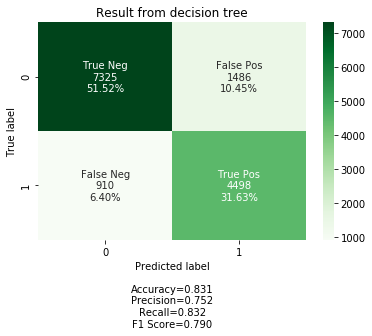

In [ ]:
# plot confusion matrix for decision tree
dt1 = np.array([[7325,1486],[910,4498]])
make_confusion_matrix(dt1,group_names=['True Neg','False Pos','False Neg','True Pos'],
                     title='Result from decision tree')

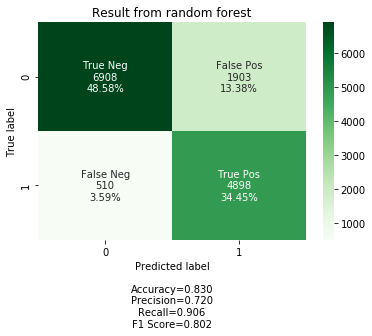

In [ ]:
# plot confusion matrix for random forest
rf1 = np.array([[6908,1903],[510,4898]])
make_confusion_matrix(rf1,group_names=['True Neg','False Pos','False Neg','True Pos'],
                      title='Result from random forest')

# Predicting offer completion for each customer on each offer type

In [ ]:
# Read non standarlized data to do group by
starb_complete = pd.read_csv('starbucks.csv')

In [ ]:
# Drop transaction
starb_complete = starb_complete[starb_complete.offer_id != 0]

# Drop informational offer related records, because that transactions cannot be tied back to info offers hence no able to predict completion
starb_complete = starb_complete[starb_complete.informational != 1]

In [ ]:
# Drop columns
starb_complete = starb_complete.drop(['Unnamed: 0', 'offer_id','received_time','viewed_time','completed_time','transaction_time'], axis = 1)

In [ ]:
# To predict if the offer would be completed
# Remove the feature that indicate the offer has been completed
starb_complete = starb_complete.drop(['time_completed_received','time_completed_received', 
                            'time_completed_viewed'], axis = 1) 
starb_complete = starb_complete.drop([ 'transaction', 'amount', 'total_reward'], axis = 1)

# also excluded offer_received since all records have the same value 1
starb_complete.drop([ 'offer_received'], axis = 1,inplace=True)

# drop informational and discount column to avoid collinearity since we are only predicting bogo and discount
starb_complete.drop([ 'informational','discount'], axis = 1,inplace=True)

In [ ]:
starb_complete.head()

,customer_id,offer_viewed,time_viewed_received,offer_completed,age,income,male,membership_days,reward_each_time,difficulty,duration,email,mobile,social,web,bogo
0,ffff82501cea40309d5fdd7edcca4a07,1.0,6.0,1.0,45,62000.0,0,608,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0
1,fff8957ea8b240a6b5e634b6ee8eafcf,1.0,24.0,0.0,71,56000.0,1,158,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0
2,fff7576017104bcc8677a8d63322b5e1,1.0,21.0,1.0,71,73000.0,1,268,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0
3,fff3ba4757bd42088c044ca26d73817a,1.0,6.0,1.0,69,83000.0,0,1040,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0
4,fff29fb549084123bd046dbc5ceb4faa,1.0,0.0,1.0,59,93000.0,0,329,2.0,10.0,10.0,1.0,1.0,1.0,1.0,0.0


## Prediction related to informational offer

In previous analysis, we did not take informational offers into consideration because we cannot know exactly whether an informational offer is completed. However, whether an informational offer is viewed can give Starbucks some insights. Hence, next part we will predict for each customer the probability of viewing an informational offer. 

In [ ]:
# Read non standarlized data to do group by
starb_complete = pd.read_csv('starbucks.csv')

In [ ]:
# Drop transaction
starb_info = starb_complete[starb_complete.offer_id != 0].copy()

# Keep only informational offer related records
starb_info = starb_info[starb_info.informational == 1]

In [ ]:
# Drop columns
starb_info = starb_info.drop(['Unnamed: 0', 'offer_id','received_time','viewed_time','completed_time','transaction_time'], axis = 1)

In [ ]:
# To predict if the offer would be viewed
# Remove the feature that indicate the offer has been viewed and columns related to completion
starb_info = starb_info.drop(['time_completed_received','time_completed_received', 
                            'time_completed_viewed','offer_completed','time_viewed_received'], axis = 1) 
starb_info = starb_info.drop([ 'transaction', 'amount', 'total_reward'], axis = 1)

# also excluded offer_received since all records have the same value 1
starb_info.drop([ 'offer_received'], axis = 1,inplace=True)

# drop informational, discount and bogo column to avoid collinearity since we are only predicting informational offer
starb_info.drop([ 'informational','discount','bogo'], axis = 1,inplace=True)

In [ ]:
# also excluded 'reward_each_time','difficulty' since all records have the same value 0
starb_info.drop([ 'reward_each_time','difficulty'], axis = 1,inplace=True)

In [ ]:
starb_info.head()

,customer_id,offer_viewed,age,income,male,membership_days,duration,email,mobile,social,web
120269,fffad4f4828548d1b5583907f2e9906b,1.0,34,34000.0,1,549,3.0,1.0,1.0,1.0,0.0
120270,fff3ba4757bd42088c044ca26d73817a,1.0,69,83000.0,0,1040,3.0,1.0,1.0,1.0,0.0
120271,ffeaa02452ef451082a0361c3ca62ef5,1.0,67,77000.0,0,522,3.0,1.0,1.0,1.0,0.0
120272,ffe5257abf8840b395e1ee6b29894637,0.0,77,75000.0,1,338,3.0,1.0,1.0,1.0,0.0
120273,ffda4545e7084ff6aaf01304fb1c1fa6,0.0,67,95000.0,0,5,3.0,1.0,1.0,1.0,0.0


In [ ]:
# group the df by cutomer_id
starb_info = starb_info.groupby(['customer_id']).mean().reset_index().drop([ 'customer_id'], axis = 1)

In [ ]:
starb_info.offer_viewed.value_counts().tolist()

[6167, 2033, 870]

In [ ]:
starb_info.offer_viewed.value_counts().index.tolist()

[1.0, 0.0, 0.5]

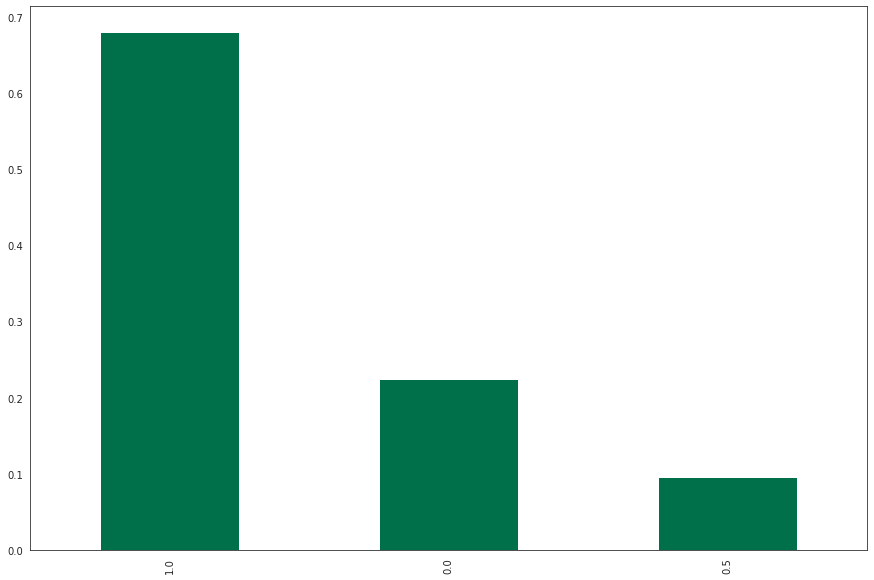

In [ ]:
starb_info.offer_viewed.value_counts(normalize=True).plot(kind='bar',color='#00704A')

In [ ]:
starb_info.offer_viewed.value_counts(normalize=True)

1.0    0.679934
0.0    0.224146
0.5    0.095921
Name: offer_viewed, dtype: float64

As shown above, this data is high imbalanced with offer viewed taking 68% of the data. One can make an easy prediction that one particular offer will be viewed and 68% of the time he will be correct. In normal circumstances, in order to do prediction on this column, we have to generate more data or draw a sample to make the dataset balanced. However, since we cannot relate any revenue to one particular informational offer based on the nature of informational offers, we can do a simple exploratory data analysis for informational offers and focus more on bogo and discount offers. 



## Prediction for bogo

In [ ]:
# slice data for bogo prediction
starb_bogo = starb_complete[starb_complete.bogo == 1].drop('bogo',axis=1).copy()

# group the df by cutomer_id
starb_bogo = starb_bogo.groupby(['customer_id']).mean().reset_index().drop([ 'customer_id'], axis = 1)

In [ ]:
starb_bogo.head()

,Unnamed: 0,offer_received,received_time,offer_viewed,viewed_time,time_viewed_received,offer_completed,completed_time,time_completed_received,time_completed_viewed,transaction,transaction_time,amount,total_reward,age,income,male,membership_days,reward_each_time,difficulty,duration,email,mobile,social,web,discount,informational
0,120268.0,1.0,408.0,1.0,456.0,48.0,1.0,414.0,6.0,-42.0,1.0,414.0,8.570,5.0,33.0,72000.0,1.0,461.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0
1,136616.5,1.0,288.0,0.5,213.0,9.0,0.5,255.0,51.0,42.0,0.5,255.0,8.620,5.0,59.0,90000.0,0.0,874.0,10.0,10.0,6.0,1.0,1.0,1.0,0.5,0.0,0.0
2,65597.0,1.0,420.0,1.0,465.0,45.0,1.0,489.0,69.0,24.0,1.0,489.0,12.425,5.0,24.0,60000.0,0.0,622.0,5.0,5.0,6.0,1.0,1.0,0.5,1.0,0.0,0.0
3,120266.0,1.0,504.0,1.0,510.0,6.0,1.0,534.0,30.0,24.0,1.0,534.0,27.920,5.0,55.0,74000.0,0.0,79.0,5.0,5.0,5.0,1.0,1.0,1.0,1.0,0.0,0.0
4,131172.5,1.0,396.0,0.5,231.0,3.0,1.0,415.5,19.5,16.5,1.0,415.5,42.170,10.0,54.0,99000.0,1.0,847.0,7.5,7.5,6.0,1.0,1.0,1.0,0.5,0.0,0.0


Next we standarlize the data for the convient of following analysis. 

In [ ]:
bogo_new = pd.DataFrame(StandardScaler().fit_transform(starb_bogo), columns=starb_bogo.columns)

# add male column back
bogo_new['male'] = starb_bogo['male'].copy()

In [ ]:
# because all offers use email as one of its distribution chanel, so the emial column is a constant 0 now after standarlization
# hence drop this column since it will not provide any useful prediction
bogo_new.drop('email',axis=1,inplace=True)

In [ ]:
bogo_new.head()

,Unnamed: 0,offer_received,received_time,offer_viewed,viewed_time,time_viewed_received,offer_completed,completed_time,time_completed_received,time_completed_viewed,transaction,transaction_time,amount,total_reward,age,income,male,membership_days,reward_each_time,difficulty,duration,mobile,social,web,discount,informational
0,0.534309,0.0,0.517282,0.515860,0.897847,0.780010,0.901685,0.859236,-0.543909,-1.268334,0.901685,0.859236,-0.179048,-0.018541,-1.232391,0.304021,1.0,-0.146278,-1.291426,-1.291426,-1.292240,0.0,0.744089,0.747572,0.0,0.0
1,0.933535,0.0,-0.305052,-1.209544,-0.509787,-0.355453,-0.215963,0.099198,0.428068,0.632236,-0.215963,0.099198,-0.177687,-0.018541,0.263184,1.134983,0.0,0.838456,1.275705,1.275705,-0.003098,0.0,0.744089,-0.742528,0.0,0.0
2,-0.800742,0.0,0.599516,0.515860,0.949981,0.692666,0.901685,1.217745,0.816859,0.224971,0.901685,1.217745,-0.074127,-0.018541,-1.750090,-0.249954,0.0,0.237601,-1.291426,-1.291426,-0.003098,0.0,-0.741977,0.747572,0.0,0.0
3,0.534260,0.0,1.175149,0.515860,1.210654,-0.442796,0.901685,1.432850,-0.025521,0.224971,0.901685,1.432850,0.347599,-0.018541,0.033095,0.396350,0.0,-1.057098,-1.291426,-1.291426,-1.292240,0.0,0.744089,0.747572,0.0,0.0
4,0.800594,0.0,0.435049,-1.209544,-0.405518,-0.530140,0.901685,0.866406,-0.252316,0.055277,0.901685,0.866406,0.735439,1.015352,-0.024427,1.550464,1.0,0.774079,-0.007861,-0.007861,-0.003098,0.0,0.744089,-0.742528,0.0,0.0


Next we do PCA to eliminate collinearity and possibly reduce dimensions. 

In [ ]:
# Define columns for prediction
X = bogo_new.copy()

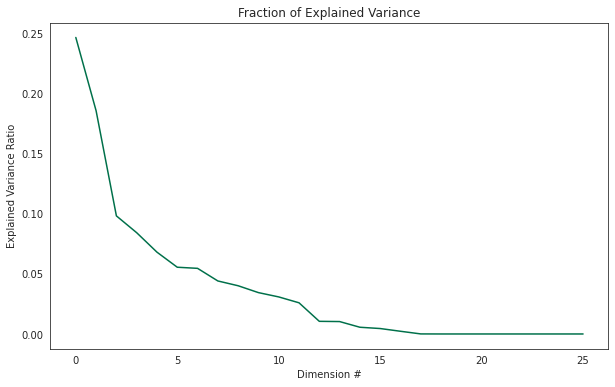

In [ ]:
# Run PCA
ini_pca = PCA(n_components = X.shape[1]).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

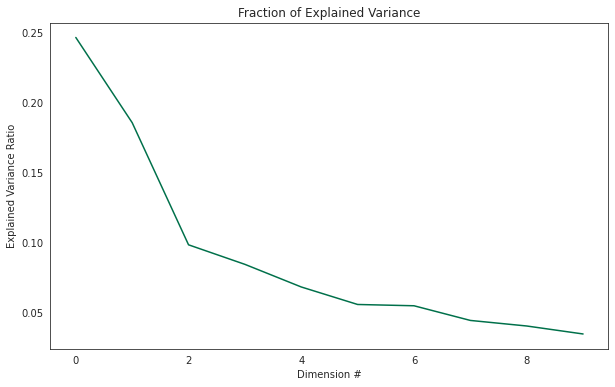

In [ ]:
ini_pca = PCA(n_components = 10).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

In [ ]:
pca = PCA(n_components = 10).fit(X)

In [ ]:
vars = pca.explained_variance_ratio_
c_names = starb_bogo.loc[:,~starb_bogo.columns.isin(['offer_completed'])].columns
sum = 0

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, c_names))
    sum += 100*vars[idx]
    print(output)

print('Total variance explained by the 10 components {0:4.1f}%'.format(sum))

Variance:  Projected dimension
------------------------------
24.6%:    -0.02 * Unnamed: 0 +  0.00 * offer_received +  0.11 * received_time +  0.06 * offer_viewed +  0.12 * viewed_time + -0.00 * time_viewed_received +  0.41 * completed_time +  0.41 * time_completed_received +  0.28 * time_completed_viewed +  0.17 * transaction +  0.41 * transaction_time +  0.41 * amount +  0.17 * total_reward +  0.35 * age +  0.08 * income +  0.16 * male + -0.05 * membership_days +  0.08 * reward_each_time + -0.03 * difficulty + -0.03 * duration +  0.02 * email + -0.00 * mobile + -0.02 * social + -0.00 * web + -0.00 * discount + -0.00 * informational
18.5%:    -0.47 * Unnamed: 0 + -0.00 * offer_received + -0.02 * received_time + -0.25 * offer_viewed + -0.17 * viewed_time + -0.03 * time_viewed_received +  0.02 * completed_time +  0.02 * time_completed_received +  0.03 * time_completed_viewed + -0.02 * transaction +  0.02 * transaction_time +  0.02 * amount + -0.02 * total_reward + -0.12 * age + -0.00 * 

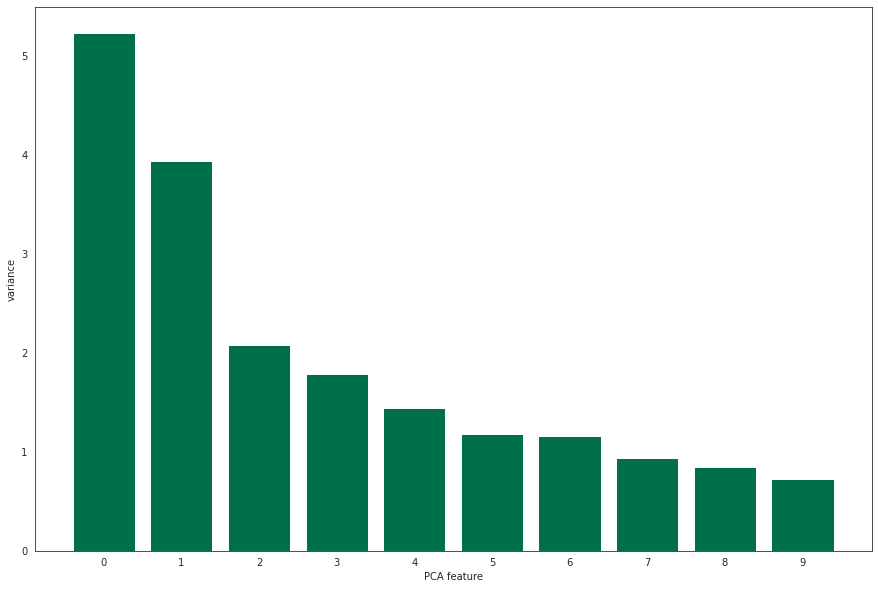

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_, color = '#00704A')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
# Fit the model
X = PCA(n_components = 10).fit_transform(X)
Y = starb_bogo.loc[:,'offer_completed']

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 

Now we are ready to apply some regression to predict the probability of completing bogo offer by each customer. 

**Linear Regression with standartized data**

In [ ]:
# build the model
lr = linear_model.LinearRegression()

# fit data to the model
lr.fit(X_train, y_train)

# Compute y_pred
lr_y_pred = lr.predict(X_test)

# Compute mse_dt
mse_lr = MSE(y_test, lr_y_pred)

# Compute rmse_dt
rmse_lr = mse_lr**(1/2)

# Print rmse_dt
print("Test set RMSE of linear regression: {:.5f}".format(rmse_lr))

Test set RMSE of linear regression: 0.35035


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
lr_MSE_CV_scores = - cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
lr_RMSE_CV = (lr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from linear regression: {:.5f}'.format(lr_RMSE_CV))

# Fit dt to the training set
lr.fit(X_train, y_train)

# Predict the labels of the training set
lr_y_pred_train = lr.predict(X_train)

# Evaluate the training set RMSE of dt
lr_RMSE_train = (MSE(y_train, lr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from linear regression: {:.5f}'.format(lr_RMSE_train))

CV RMSE from linear regression: 0.35134
Train RMSE from linear regression: 0.35116


**Decision Tree Regressor with standartized data**

In [ ]:
# build the model
dtr = DecisionTreeRegressor(max_depth=6)

# fit data to the model
dtr.fit(X_train, y_train)

# Compute y_pred
dtr_y_pred = dtr.predict(X_test)

# Compute mse_dt
mse_dtr = MSE(y_test, dtr_y_pred)

# Compute rmse_dt
rmse_dtr = mse_dtr**(1/2)

# Print rmse_dt
print("Test set RMSE of Decision Tree Regression: {:.5f}".format(rmse_dtr))

Test set RMSE of Decision Tree Regression: 0.16820


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
dtr_MSE_CV_scores = - cross_val_score(dtr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
dtr_RMSE_CV = (dtr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_CV))

# Fit dt to the training set
dtr.fit(X_train, y_train)

# Predict the labels of the training set
dtr_y_pred_train = dtr.predict(X_train)

# Evaluate the training set RMSE of dt
dtr_RMSE_train = (MSE(y_train, dtr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_train))

CV RMSE from decision tree regression: 0.16850
Train RMSE from decision tree regression: 0.14769


**Random Forest Regressor with standartized data**

In [ ]:
# build the model
rfr = RandomForestRegressor(max_depth = 7)

# fit data to the model
rfr.fit(X_train, y_train)

# Compute y_pred
rfr_y_pred = rfr.predict(X_test)

# Compute mse_dt
mse_rfr = MSE(y_test, rfr_y_pred)

# Compute rmse_dt
rmse_rfr = mse_rfr**(1/2)

# Print rmse_dt
print("Test set RMSE of random forest Regression: {:.5f}".format(rmse_rfr))

Test set RMSE of random forest Regression: 0.10996


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
rfr_MSE_CV_scores = - cross_val_score(rfr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
rfr_RMSE_CV = (rfr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from random forest regression: {:.5f}'.format(rfr_RMSE_CV))

# Fit dt to the training set
rfr.fit(X_train, y_train)

# Predict the labels of the training set
rfr_y_pred_train = rfr.predict(X_train)

# Evaluate the training set RMSE of dt
rfr_RMSE_train = (MSE(y_train, rfr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from random forest regression: {:.5f}'.format(rfr_RMSE_train))

CV RMSE from random forest regression: 0.10643
Train RMSE from random forest regression: 0.09082


**Gradient Boosting Regressor with standartized data**

In [ ]:
# build the model
gbr = GradientBoostingRegressor(max_depth=4,n_estimators=200)

# fit data to the model
gbr.fit(X_train, y_train)

# Compute y_pred
gbr_y_pred = gbr.predict(X_test)

# Compute mse_knn
mse_gbr = MSE(y_test, gbr_y_pred)

# Compute rmse_knn
rmse_gbr = mse_gbr**(1/2)

# Print rmse_dt
print("Test set RMSE of Gradient Boosting Regression: {:.5f}".format(rmse_gbr))

Test set RMSE of Gradient Boosting Regression: 0.05914


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
gbr_MSE_CV_scores = - cross_val_score(gbr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
gbr_RMSE_CV = (gbr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from Gradient Boosting Regression: {:.5f}'.format(gbr_RMSE_CV))

# Predict the labels of the training set
gbr_y_pred_train = gbr.predict(X_train)

# Evaluate the training set RMSE of dt
gbr_RMSE_train = (MSE(y_train, gbr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from Gradient Boosting Regression: {:.5f}'.format(gbr_RMSE_train))

CV RMSE from Gradient Boosting Regression: 0.05802
Train RMSE from Gradient Boosting Regression: 0.04293


**Model Summary and Comparison**

| Model                | RMSE    |CV RMSE|Train RMSE|
|----------------------|---------|--------|--------|
| **Gradient Boosting**    | **0.05914** |0.05802|0.04293|
| Random forest        | 0.10996 |0.10643|0.09082|
| Decision tree        | 0.16820 |0.16850|0.14769|
| linear regression    | 0.35035 |0.35134|0.35116|

The best result is from Gradient Boosting Regressor model, with RMSE = **0.059**. This model will predict the probability that the customer will complete the bogo offer. When the probability is over 0.5, we consider this customer is more likely than not to complete a bogo offer if he recieved one. 

Next we will work on discount offer data.

## Prediction for discount

In [ ]:
# slice data for discount prediction
starb_discount = starb_complete[starb_complete.bogo == 0].drop('bogo',axis=1).copy()

# group the df by cutomer_id
starb_discount = starb_discount.groupby(['customer_id']).mean().reset_index().drop([ 'customer_id'], axis = 1)

In [ ]:
starb_discount.head()

,Unnamed: 0,offer_received,received_time,offer_viewed,viewed_time,time_viewed_received,offer_completed,completed_time,time_completed_received,time_completed_viewed,transaction,transaction_time,amount,total_reward,age,income,male,membership_days,reward_each_time,difficulty,duration,email,mobile,social,web,discount,informational
0,95399.222222,0.444444,176.000000,0.333333,122.666667,10.666667,0.222222,122.666667,2.666667,-1.333333,0.777778,436.666667,13.225556,0.444444,33.0,72000.0,1.0,461.0,0.444444,2.222222,2.666667,0.444444,0.444444,0.222222,0.333333,0.222222,0.222222
1,102565.875000,0.250000,84.000000,0.250000,84.000000,0.000000,0.125000,35.250000,14.250000,33.750000,0.875000,313.500000,24.607500,0.500000,59.0,90000.0,0.0,874.0,0.250000,1.250000,1.625000,0.250000,0.250000,0.250000,0.125000,0.125000,0.125000
2,118833.909091,0.181818,52.363636,0.181818,52.363636,0.000000,0.090909,20.181818,4.909091,4.909091,0.909091,320.181818,11.745455,0.272727,24.0,60000.0,0.0,622.0,0.272727,0.636364,0.909091,0.181818,0.181818,0.181818,0.090909,0.090909,0.090909
3,105931.736842,0.210526,59.368421,0.157895,40.421053,7.578947,0.105263,60.000000,18.315789,4.421053,0.894737,376.105263,2.544211,0.473684,26.0,73000.0,0.0,400.0,0.368421,1.578947,1.421053,0.210526,0.157895,0.105263,0.157895,0.105263,0.105263
4,100353.200000,0.200000,49.800000,0.100000,11.100000,2.700000,0.050000,12.900000,4.500000,3.600000,0.850000,226.800000,3.425500,0.100000,19.0,65000.0,0.0,716.0,0.450000,2.000000,1.500000,0.200000,0.150000,0.100000,0.150000,0.150000,0.050000


Next we standarlize the data for the convient of following analysis. 

In [ ]:
discount_new = pd.DataFrame(StandardScaler().fit_transform(starb_discount), columns=starb_discount.columns)

# add male column back
discount_new['male'] = starb_discount['male'].copy()

In [ ]:
# because all offers use email as one of its distribution chanel, so the emial column is a constant 0 now after standarlization
# hence drop this column since it will not provide any useful prediction
discount_new.drop('email',axis=1,inplace=True)

In [ ]:
discount_new.head()

,Unnamed: 0,offer_received,received_time,offer_viewed,viewed_time,time_viewed_received,offer_completed,completed_time,time_completed_received,time_completed_viewed,transaction,transaction_time,amount,total_reward,age,income,male,membership_days,reward_each_time,difficulty,duration,mobile,social,web,discount,informational
0,1.073789,0.476954,0.733580,0.436157,0.434759,0.301578,0.539751,0.881899,-0.420223,-0.422458,-0.110131,1.145036,0.035483,-0.034074,-1.229198,0.304248,1.0,-0.148532,-0.373962,-0.184141,0.205485,0.814255,0.363468,0.239132,-0.023105,0.881785
1,1.373004,-0.381378,-0.322690,0.039812,-0.025676,-0.525953,-0.080343,-0.298217,0.189558,1.842039,0.347000,0.022858,0.768356,0.056882,0.265384,1.136424,0.0,0.835375,-0.674897,-0.566461,-0.399743,-0.133549,0.538260,-0.737377,-0.521045,0.120150
2,2.052209,-0.682351,-0.685913,-0.284470,-0.402395,-0.525953,-0.297778,-0.501636,-0.302175,-0.019533,0.507293,0.083737,-0.059820,-0.315210,-1.746553,-0.250536,0.0,0.235025,-0.639722,-0.807770,-0.815700,-0.465895,0.109225,-0.897169,-0.695647,-0.146917
3,1.513532,-0.555625,-0.605489,-0.398253,-0.544605,0.062030,-0.206226,0.035905,0.403594,-0.051034,0.439801,0.593258,-0.652280,0.013798,-1.631585,0.350480,0.0,-0.293855,-0.491621,-0.437105,-0.518240,-0.582508,-0.372498,-0.583191,-0.622130,-0.034468
4,1.280622,-0.602091,-0.715346,-0.673609,-0.893754,-0.316484,-0.558700,-0.599940,-0.323711,-0.104030,0.229452,-0.767069,-0.595534,-0.597999,-2.033972,-0.019376,0.0,0.458965,-0.365364,-0.271528,-0.472370,-0.620990,-0.405616,-0.620196,-0.393003,-0.467397


Next we do PCA to eliminate collinearity and possibly reduce dimensions. 

In [ ]:
# Define columns for prediction
X = discount_new.copy()

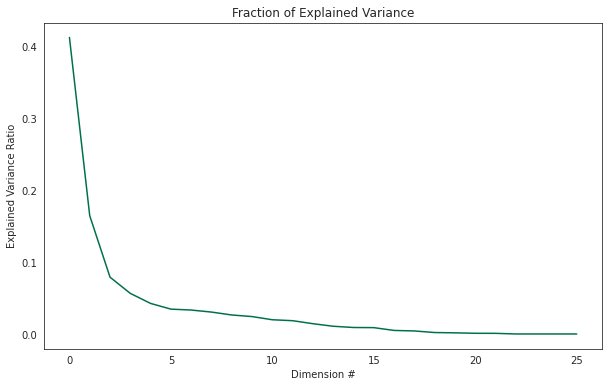

In [ ]:
# Run PCA
ini_pca = PCA(n_components = X.shape[1]).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

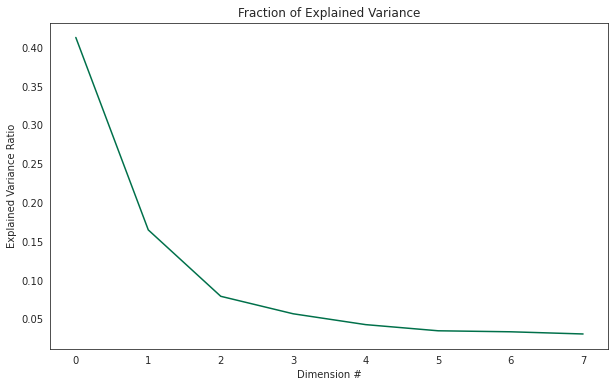

In [ ]:
ini_pca = PCA(n_components = 8).fit(X)
fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('Dimension #')
ax.set_ylabel('Explained Variance Ratio')
ax.set_title('Fraction of Explained Variance')
ax.plot(ini_pca.explained_variance_ratio_, color = '#00704A')

In [ ]:
pca = PCA(n_components = 10).fit(X)

In [ ]:
vars = pca.explained_variance_ratio_
c_names = starb_discount.loc[:,~starb_discount.columns.isin(['offer_completed'])].columns
sum = 0

print('Variance:  Projected dimension')
print('------------------------------')
for idx, row in enumerate(pca.components_):
    output = '{0:4.1f}%:    '.format(100.0 * vars[idx])
    output += " + ".join("{0:5.2f} * {1:s}".format(val, name) \
                      for val, name in zip(row, c_names))
    sum += 100*vars[idx]
    print(output)

print('Total variance explained by the 10 components {0:4.1f}%'.format(sum))

Variance:  Projected dimension
------------------------------
41.3%:    -0.02 * Unnamed: 0 +  0.30 * offer_received +  0.27 * received_time +  0.26 * offer_viewed +  0.24 * viewed_time +  0.11 * time_viewed_received +  0.19 * completed_time +  0.19 * time_completed_received +  0.16 * time_completed_viewed +  0.12 * transaction + -0.17 * transaction_time + -0.10 * amount +  0.03 * total_reward +  0.17 * age +  0.06 * income +  0.11 * male + -0.02 * membership_days + -0.08 * reward_each_time +  0.26 * difficulty +  0.25 * duration +  0.30 * email +  0.26 * mobile +  0.21 * social +  0.29 * web +  0.28 * discount +  0.10 * informational
16.5%:    -0.11 * Unnamed: 0 + -0.12 * offer_received + -0.09 * received_time + -0.09 * offer_viewed + -0.07 * viewed_time + -0.06 * time_viewed_received +  0.35 * completed_time +  0.34 * time_completed_received +  0.30 * time_completed_viewed +  0.21 * transaction +  0.38 * transaction_time +  0.35 * amount +  0.21 * total_reward +  0.34 * age +  0.04 * 

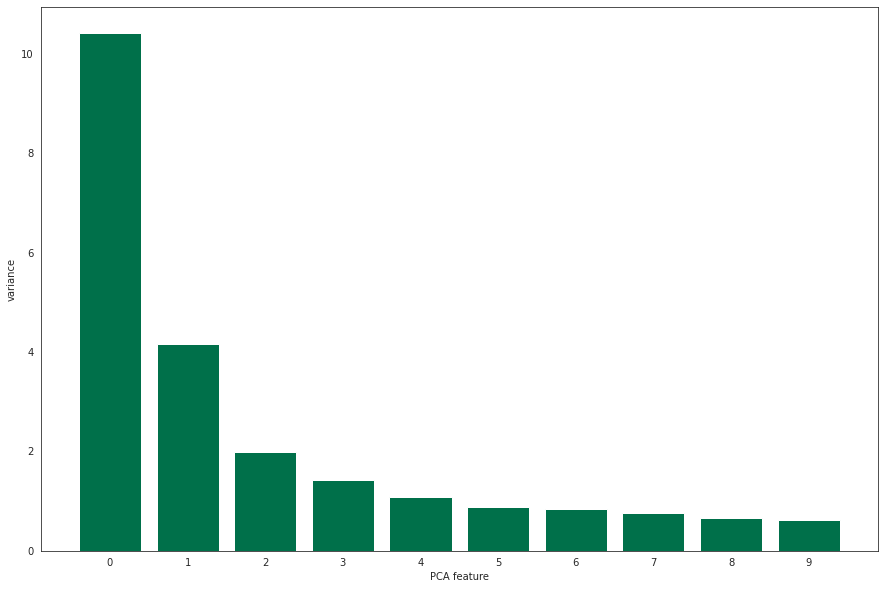

In [ ]:
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_, color = '#00704A')
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

In [ ]:
# Fit the model
X = PCA(n_components = 10).fit_transform(X)
Y = starb_discount.loc[:,'offer_completed']

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 100) 

Now we are ready to apply some regression to predict the probability of completing discount offer by each customer. 

**Linear Regression with standartized data**

In [ ]:
# build the model
lr = linear_model.LinearRegression()

# fit data to the model
lr.fit(X_train, y_train)

# Compute y_pred
lr_y_pred = lr.predict(X_test)

# Compute mse_dt
mse_lr = MSE(y_test, lr_y_pred)

# Compute rmse_dt
rmse_lr = mse_lr**(1/2)

# Print rmse_dt
print("Test set RMSE of linear regression: {:.5f}".format(rmse_lr))

Test set RMSE of linear regression: 0.04278


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
lr_MSE_CV_scores = - cross_val_score(lr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
lr_RMSE_CV = (lr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from linear regression: {:.5f}'.format(lr_RMSE_CV))

# Fit dt to the training set
lr.fit(X_train, y_train)

# Predict the labels of the training set
lr_y_pred_train = lr.predict(X_train)

# Evaluate the training set RMSE of dt
lr_RMSE_train = (MSE(y_train, lr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from linear regression: {:.5f}'.format(lr_RMSE_train))

CV RMSE from linear regression: 0.04274
Train RMSE from linear regression: 0.04262


**Decision Tree Regressor with standartized data**

In [ ]:
# build the model
dtr = DecisionTreeRegressor(max_depth=5)

# fit data to the model
dtr.fit(X_train, y_train)

# Compute y_pred
dtr_y_pred = dtr.predict(X_test)

# Compute mse_dt
mse_dtr = MSE(y_test, dtr_y_pred)

# Compute rmse_dt
rmse_dtr = mse_dtr**(1/2)

# Print rmse_dt
print("Test set RMSE of Decision Tree Regression: {:.5f}".format(rmse_dtr))

Test set RMSE of Decision Tree Regression: 0.05239


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
dtr_MSE_CV_scores = - cross_val_score(dtr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
dtr_RMSE_CV = (dtr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_CV))

# Fit dt to the training set
dtr.fit(X_train, y_train)

# Predict the labels of the training set
dtr_y_pred_train = dtr.predict(X_train)

# Evaluate the training set RMSE of dt
dtr_RMSE_train = (MSE(y_train, dtr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from decision tree regression: {:.5f}'.format(dtr_RMSE_train))

CV RMSE from decision tree regression: 0.05566
Train RMSE from decision tree regression: 0.05113


**Random Forest Classifier with standartized data**

In [ ]:
# build the model
rfr = RandomForestRegressor(max_depth = 7)

# fit data to the model
rfr.fit(X_train, y_train)

# Compute y_pred
rfr_y_pred = rfr.predict(X_test)

# Compute mse_dt
mse_rfr = MSE(y_test, rfr_y_pred)

# Compute rmse_dt
rmse_rfr = mse_rfr**(1/2)

# Print rmse_dt
print("Test set RMSE of random forest Regression: {:.5f}".format(rmse_rfr))

Test set RMSE of random forest Regression: 0.04002


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
rfr_MSE_CV_scores = - cross_val_score(rfr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
rfr_RMSE_CV = (rfr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from random forest regression: {:.5f}'.format(rfr_RMSE_CV))

# Fit dt to the training set
rfr.fit(X_train, y_train)

# Predict the labels of the training set
rfr_y_pred_train = rfr.predict(X_train)

# Evaluate the training set RMSE of dt
rfr_RMSE_train = (MSE(y_train, rfr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from random forest regression: {:.5f}'.format(rfr_RMSE_train))

CV RMSE from random forest regression: 0.04060
Train RMSE from random forest regression: 0.03413


**Gradient Boosting Classifier with standartized data**

In [ ]:
# build the model
gbr = GradientBoostingRegressor(max_depth=3,n_estimators=200)

# fit data to the model
gbr.fit(X_train, y_train)

# Compute y_pred
gbr_y_pred = gbr.predict(X_test)

# Compute mse_knn
mse_gbr = MSE(y_test, gbr_y_pred)

# Compute rmse_knn
rmse_gbr = mse_gbr**(1/2)

# Print rmse_dt
print("Test set RMSE of Gradient Boosting Regression: {:.5f}".format(rmse_gbr))

Test set RMSE of Gradient Boosting Regression: 0.03760


In [ ]:
# CV RMSE validation

# Compute the array containing the 10-folds CV MSEs
gbr_MSE_CV_scores = - cross_val_score(gbr, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 

# Compute the 10-folds CV RMSE
gbr_RMSE_CV = (gbr_MSE_CV_scores.mean())**(1/2)

# Print RMSE_CV
print('CV RMSE from Gradient Boosting Regression: {:.5f}'.format(gbr_RMSE_CV))

# Predict the labels of the training set
gbr_y_pred_train = gbr.predict(X_train)

# Evaluate the training set RMSE of dt
gbr_RMSE_train = (MSE(y_train, gbr_y_pred_train))**(1/2)

# Print RMSE_train
print('Train RMSE from Gradient Boosting Regression: {:.5f}'.format(gbr_RMSE_train))

CV RMSE from Gradient Boosting Regression: 0.03702
Train RMSE from Gradient Boosting Regression: 0.03188


**Model Summary and Comparison**

| Model                | RMSE    |CV RMSE|Train RMSE|
|----------------------|---------|--------|--------|
| **Gradient Boosting**    | **0.03760** |0.03702|0.03188|
| Random forest        | 0.04004 |0.04060|0.03413|
| Decision tree        | 0.05239 |0.05566|0.05113|
| linear regression    | 0.04278 |0.04274|0.04262|

The best result is from Gradient Boosting Regressor model, with RMSE = 0.038. This model will predict the probability that the customer will complete the discount offer. When the probability is over 0.5, we consider this customer is more likely than not to complete a discount offer if he recieved one.  

Using above results, we can make offer type recommendation to each customer based on her probability to complete that type of offer. If this customer has one probability over 0.5, then the system can mark this customer as bogo/discount-preferred. If both probabilities of this customer is over 0.5, then the system can recommend both types, and recommend an extra one for the type with higher probability.